### Descripción de las poses:

1. **`downdog` (Perro mirando hacia abajo)**  
   - **Descripción**: Manos y pies en el piso, formando un ángulo invertido con el cuerpo (pose típica del saludo al sol).  
   - **Postura clave**: Caderas elevadas y espalda recta.  

2. **`goddess` (Diosa)**  
   - **Descripción**: Piernas abiertas con las rodillas flexionadas, brazos extendidos hacia arriba al costado de la cabeza.  
   - **Postura clave**: Postura de fuerza y apertura.  

3. **`plank` (Plancha)**  
   - **Descripción**: Cuerpo recto en paralelo al suelo, apoyándose únicamente en las palmas de las manos y los dedos de los pies.  
   - **Postura clave**: Fuerte contracción del abdomen para mantener el equilibrio.  

4. **`tree` (Árbol)**  
   - **Descripción**: De pie en un solo pie, con las manos juntas frente al pecho o extendidas hacia arriba.  
   - **Postura clave**: Pierna elevada con el pie apoyado en el muslo interno contrario.  

5. **`warrior2` (Guerrero 2)**  
   - **Descripción**: Piernas abiertas con una rodilla flexionada y brazos extendidos en línea recta a los costados.  
   - **Postura clave**: Apertura del pecho y mirada hacia la mano delantera.  


## Librerias

In [1]:
!pip install mediapipe
!pip install fiftyone
!pip install fiftyone


In [2]:
!pip install tensorflow


In [3]:
seed = 3

In [4]:
import cv2
import os
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import LabelEncoder
import requests




# Configuracion y preparacion del uso de MediaPipe Pose

In [5]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose()

In [6]:
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    print("Modelo Pose inicializado, listo para procesar imágenes.")


Modelo Pose inicializado, listo para procesar imágenes.


# 1 | Data Load

### Cargar archivos desde GitHub

In [7]:

repo_owner = 'brimoresco'
repo_name = 'cv-tp-yoga-moresco'
train_dir = 'TEST'
test_dir = 'TRAIN'
branch = 'main'

# Función para obtener el listado de archivos desde el repositorio de GitHub
def get_github_file_list(owner, repo, path, branch='main'):
    url = f'https://api.github.com/repos/{owner}/{repo}/contents/{path}?ref={branch}'
    response = requests.get(url)
    response.raise_for_status()  # Asegura que la solicitud sea exitosa
    files = response.json()
    return files




Como mi dataset se encuentra en un repositorio, y necesito descargar las imágenes desde URLs en tiempo real:

In [8]:
def load_image_from_url(url):
    resp = requests.get(url)
    img = np.array(bytearray(resp.content), dtype=np.uint8)
    img = cv2.imdecode(img, -1)
    if img is None:
        print(f"Error loading image from {url}")
    return img


###  Carga y procesamiento de datos

- Carga imágenes desde GitHub y las procesa para detectar poses humanas, y almacena los resultados en un DataFrame para su posterior uso en entrenamiento y evaluación de modelos.

In [9]:
import pandas as pd

def data_loader_to_dataframe(path):
    data = []  # Para almacenar datos estructurados como filas de un DataFrame
    pose = mp.solutions.pose.Pose() # se crea un objeto para detectar las poses humanas en las imágenes
    s, f = 0, 0  # Contadores de éxito y fallo

    # Obtener la lista de etiquetas (carpetas de clase)
    labels = [item['name'] for item in get_github_file_list(repo_owner, repo_name, path)]

    for label in tqdm(labels):
        label_path = os.path.join(path, label)
        files = get_github_file_list(repo_owner, repo_name, label_path)  # Obtener archivos en la carpeta

        for file in files:
            image_url = file['download_url']  # URL cruda para descargar la imagen

            if image_url:
                img = load_image_from_url(image_url)
                if img is not None and img.size != 0:
                    # -------- pose detection -------
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    results = pose.process(img_rgb)
                    if results.pose_landmarks:
                        # Extraer los keypoints
                        landmarks = [
                            [lmk.x, lmk.y, lmk.z] for lmk in results.pose_landmarks.landmark
                        ]
                        # Añadir una fila al conjunto de datos
                        data.append({
                            "url_img": image_url,
                            "keypoints": landmarks,
                            "pose_name": label
                        })
                        s += 1
                    else:
                        f += 1
                else:
                    print(f"Error loading image from {image_url}")
            else:
                print(f"Invalid image URL: {image_url}")

    mode = path.split('/')[-1]
    print(f'{mode} total: success {s}, fail {f}')

    # Crear un DataFrame a partir de los datos recolectados
    df = pd.DataFrame(data)
    return df


In [10]:
# Crear los DataFrames de train y test
train_df = data_loader_to_dataframe(train_dir)
test_df = data_loader_to_dataframe(test_dir)



100%|██████████| 5/5 [01:35<00:00, 19.16s/it]


TEST total: success 434, fail 36


100%|██████████| 5/5 [02:56<00:00, 35.33s/it]

TRAIN total: success 970, fail 110


In [11]:
train_df

,url_img,keypoints,pose_name
0,https://raw.githubusercontent.com/brimoresco/c...,"[[0.5125513672828674, 0.7227011919021606, -0.0...",downdog
1,https://raw.githubusercontent.com/brimoresco/c...,"[[0.4308083653450012, 0.5596960783004761, -1.0...",downdog
2,https://raw.githubusercontent.com/brimoresco/c...,"[[0.4426484704017639, 0.4210481345653534, -0.9...",downdog
3,https://raw.githubusercontent.com/brimoresco/c...,"[[0.5500473380088806, 0.6354166865348816, -0.4...",downdog
4,https://raw.githubusercontent.com/brimoresco/c...,"[[0.3646571636199951, 0.7277389764785767, -0.0...",downdog
...,...,...,...
429,https://raw.githubusercontent.com/brimoresco/c...,"[[0.4356313943862915, 0.3863220810890198, -0.2...",warrior2
430,https://raw.githubusercontent.com/brimoresco/c...,"[[0.5075961947441101, 0.2237154096364975, -0.2...",warrior2
431,https://raw.githubusercontent.com/brimoresco/c...,"[[0.47134068608283997, 0.2052956372499466, -0....",warrior2
432,https://raw.githubusercontent.com/brimoresco/c...,"[[0.38130664825439453, 0.05231284722685814, -0...",warrior2


- x_test_raw: Es la variable que almacenará las características del conjunto de prueba.
- y_test_raw: Es la variable que almacenará las etiquetas del conjunto de prueba.

In [12]:
# Para el conjunto de entrenamiento
x_train_raw = train_df['keypoints']  # Características (keypoints)
y_train_raw = train_df['pose_name']  # Etiquetas (pose_name)

# Para el conjunto de prueba
x_test_raw = test_df['keypoints']  # Características (keypoints)
y_test_raw = test_df['pose_name']  # Etiquetas (pose_name)

# Verifica las formas de las variables
print("train dataset: ", x_train_raw.shape, y_train_raw.shape)
print("test dataset: ", x_test_raw.shape, y_test_raw.shape)


train dataset:  (434,) (434,)
test dataset:  (970,) (970,)


### Preparación de los datos

In [13]:
# Codificar las clases
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
le.fit(labels)
y_train_raw = le.transform(y_train_raw)
y_test_raw = le.transform(y_test_raw)


# dataset

Convertimos los datos de pose y etiquetas en tensores para PyTorch.

In [14]:
# Aplanar los datos de entrada
x_train_flat = np.array([np.array(kp).flatten() for kp in x_train_raw])
x_test_flat = np.array([np.array(kp).flatten() for kp in x_test_raw])

# Asegúrate de que las etiquetas sean arreglos NumPy y aplánalas (si corresponde)
y_train_flat = np.array([np.array(label).flatten() for label in y_train_raw])
y_test_flat = np.array([np.array(label).flatten() for label in y_test_raw])

# Verificar las formas resultantes
print("Forma de x_train_flat:", x_train_flat.shape)
print("Forma de y_train_flat:", y_train_flat.shape)
print("Forma de x_test_flat:", x_test_flat.shape)
print("Forma de y_test_flat:", y_test_flat.shape)


Forma de x_train_flat: (434, 99)
Forma de y_train_flat: (434, 1)
Forma de x_test_flat: (970, 99)
Forma de y_test_flat: (970, 1)


In [15]:

# Convertir a tensores
epochs = 10
batch_size = 128
lr = 0.01

x_train = torch.FloatTensor(x_train_flat)
y_train = torch.LongTensor(y_train_flat)
x_test = torch.FloatTensor(x_test_flat)
y_test = torch.LongTensor(y_test_flat)

In [17]:
input_shape = (33 * 3,)  # Cada muestra tiene 33 puntos clave con 3 coordenadas cada uno


In [16]:
assert len(x_train) == len(y_train), "x_train y y_train no coinciden en longitud"
assert len(x_test) == len(y_test), "x_test y y_test no coinciden en longitud"


### Creación de DataLoaders

- DataLoader es una clase de PyTorch que la vamos a usar para cargar y gestionar los datos de manera eficiente, creando iteradores para mini-batches, que es un subconjunto de datos que se utiliza para entrenar el modelo en una sola iteración, en lugar de usar todo el conjunto de datos.

In [18]:

# Combina las características (x) y etiquetas (y).
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

# Crear iteradores para cargar los datos en mini-batches
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, drop_last=True, shuffle=True)


In [19]:
print("Clases aprendidas por el codificador:", le.classes_)
print("Etiquetas únicas en y_train_raw:", np.unique(y_train_raw))


Clases aprendidas por el codificador: ['downdog' 'goddess' 'plank' 'tree' 'warrior2']
Etiquetas únicas en y_train_raw: [0 1 2 3 4]


# model A

In [20]:
# Importar TensorFlow y otros módulos necesarios
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [21]:
# Función para construir el modelo basado en keypoints
def build_keypoints_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    # Red neuronal densa (MLP)
    x = Dense(128, activation='relu')(i)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels, activation='softmax')(x)

    return tf.keras.Model(inputs=[i], outputs=[x])

# Definir forma de entrada y número de clases
input_shape = (len(x_train[0]),)  # Longitud de los keypoints
num_classes = len(le.classes_)  # Número de poses (etiquetas)



In [22]:
# Construir el modelo
model_keypoints = build_keypoints_model(input_shape, num_classes)

# Compilar el modelo
model_keypoints.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model_keypoints.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 99)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,381 (83.52 KB)

 Trainable params: 21,381 (83.52 KB)

 Non-trainable params: 0 (0.00 B)

### ENTRAMOS

In [25]:
# Entrenamiento del modelo
#EPOCHS = 30
EPOCHS = 100

history = model_keypoints.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    batch_size=batch_size
)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7237 - loss: 0.7353 - val_accuracy: 0.7258 - val_loss: 0.8499
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7098 - loss: 0.7460 - val_accuracy: 0.7351 - val_loss: 0.8320
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7435 - loss: 0.6974 - val_accuracy: 0.7412 - val_loss: 0.8239
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7525 - loss: 0.6980 - val_accuracy: 0.7351 - val_loss: 0.8232
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7413 - loss: 0.7267 - val_accuracy: 0.7165 - val_loss: 0.8314
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7721 - loss: 0.6735 - val_accuracy: 0.7361 - val_loss: 0.8198
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7387 - loss: 0.6873 - val_accuracy: 0.7392 - val_loss: 0.8056
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7821 - loss: 0.6489 - val_accuracy: 0.7443 - val_loss:

### Visualización de resultados

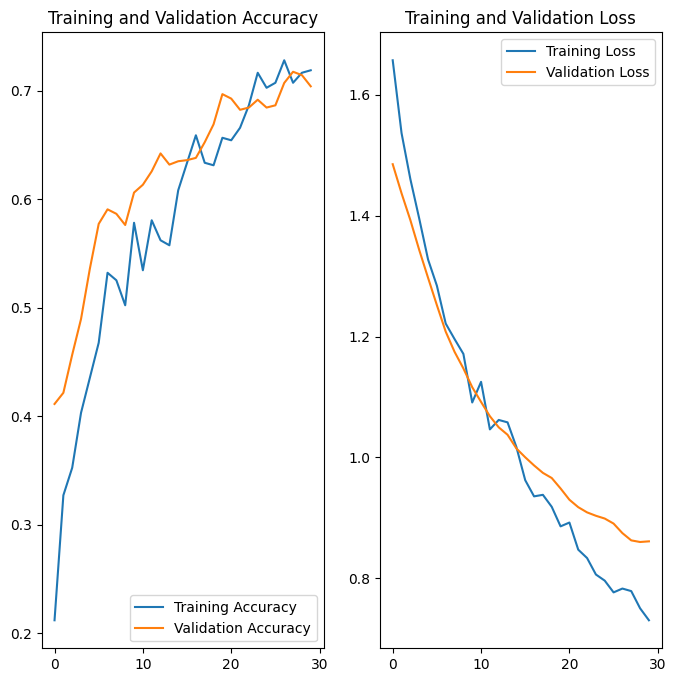

In [24]:
# Graficar precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Captura en tiempo real desde la cámara

In [27]:
import cv2
import numpy as np
import torch

# Función para cargar y procesar una imagen
def preprocess_image(image_path):
    # Cargar imagen
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: No se pudo cargar la imagen desde {image_path}")
        return None

    # Convertir a RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Usar MediaPipe Pose para extraer landmarks
    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
        results = pose.process(img_rgb)
        if results.pose_landmarks:
            # Extraer coordenadas normalizadas (x, y, z)
            landmarks = []
            for lmk in results.pose_landmarks.landmark:
                landmarks.append([lmk.x, lmk.y, lmk.z])
            return np.array(landmarks).flatten()  # Aplanar las coordenadas
        else:
            print("No se detectaron landmarks en la imagen.")
            return None


In [ ]:
# Función para predecir la clase de la pose
def predict_pose(image_path, model, label_encoder, device):
    # Preprocesar la imagen
    landmarks = preprocess_image(image_path)
    if landmarks is None:
        return None

    # Convertir landmarks en tensor
    input_tensor = torch.FloatTensor(landmarks).unsqueeze(0).to(device)

    # Realizar predicción
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        prediction = torch.argmax(logits, dim=1).item()

    # Decodificar la clase
    predicted_class = label_encoder.inverse_transform([prediction])[0]
    return predicted_class

# Lista de etiquetas
labels = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

# Cargar el codificador con las etiquetas
le = LabelEncoder()
le.fit(labels)

# Usar el flujo con una imagen
image_path = "/content/00000048.jpg"  # Ruta de la imagen que deseas analizar
predicted_pose = predict_pose(image_path, model, le, device)

pose_descriptions = {
    'downdog': 'Manos y pies en el piso, formando un ángulo invertido con el cuerpo (saludo al sol).',
    'goddess': 'Piernas abiertas con rodillas flexionadas, brazos extendidos hacia arriba al costado de la cabeza.',
    'plank': 'Cuerpo recto en paralelo al suelo, apoyándose en las palmas de las manos y los dedos de los pies.',
    'tree': 'De pie en un solo pie, manos juntas frente al pecho o extendidas hacia arriba.',
    'warrior2': 'Piernas abiertas, una rodilla flexionada, brazos extendidos en línea recta a los costados.'
}

# Mostrar predicción con descripción
if predicted_pose:
    print(f"La pose detectada en la imagen es: {predicted_pose}")
    print(f"Descripción: {pose_descriptions[predicted_pose]}")
else:
    print("No se pudo realizar la predicción.")


Error: No se pudo cargar la imagen desde /content/00000052.jpg
No se pudo realizar la predicción.


ahora generame un flujo para que yo le pase una img y me diga que pose hago

In [28]:
def predict_pose(image_path, model, label_encoder):
    """
    Predice la pose de yoga basada en una imagen de entrada.

    Args:
        image_path (str): Ruta de la imagen a predecir.
        model (tf.keras.Model): Modelo entrenado para predecir poses de yoga.
        label_encoder (LabelEncoder): Codificador de etiquetas usado durante el entrenamiento.

    Returns:
        str: Nombre de la pose predicha.
    """
    # Cargar la imagen
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen desde la ruta: {image_path}")

    # Convertir a RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detectar keypoints usando MediaPipe
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        results = pose.process(img_rgb)
        if not results.pose_landmarks:
            raise ValueError("No se detectaron keypoints en la imagen.")

        # Extraer los keypoints en un formato plano
        keypoints = [
            [landmark.x, landmark.y, landmark.z]
            for landmark in results.pose_landmarks.landmark
        ]
        keypoints_flat = np.array(keypoints).flatten().reshape(1, -1)  # Aplanar y ajustar la forma

    # Realizar la predicción
    predictions = model.predict(keypoints_flat)
    predicted_label = np.argmax(predictions, axis=1)  # Índice de la clase predicha

    # Decodificar la etiqueta
    pose_name = label_encoder.inverse_transform(predicted_label)[0]

    return pose_name


In [33]:
# Ruta de una imagen de prueba
test_image_path = "/content/00000111.jpg" #warrior2

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le)

print(f"La pose predicha es: {predicted_pose}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
La pose predicha es: warrior2


In [34]:
# Ruta de una imagen de prueba
test_image_path = "/content/00000051.png" #tree

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le)

print(f"La pose predicha es: {predicted_pose}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
La pose predicha es: tree


In [ ]:
# Ruta de una imagen de prueba
test_image_path = "/content/00000052.jpg"

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le)

print(f"La pose predicha es: {predicted_pose}")


In [35]:
# Ruta de una imagen de prueba
test_image_path = "/content/00000119.jpg" #plank

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le)

print(f"La pose predicha es: {predicted_pose}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
La pose predicha es: plank


In [36]:
# Ruta de una imagen de prueba
test_image_path = "/content/00000083.jpg" #goddess

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le)

print(f"La pose predicha es: {predicted_pose}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
La pose predicha es: goddess


In [37]:
# Ruta de una imagen de prueba
test_image_path = "/content/00000045.jpg" #downdog

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le)

print(f"La pose predicha es: {predicted_pose}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
La pose predicha es: downdog


In [38]:
# Ruta de una imagen de prueba
test_image_path = "/content/bri-yoga.jpg" #downdog

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le)

print(f"La pose predicha es: {predicted_pose}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
La pose predicha es: warrior2
